# Wrangle and Analyze WeRateDogs Twitter Archive

## Introduction

WeRateDogs (https://twitter.com/dog_rates) is a Twitter account that is well-known for its pictures and commentary of dogs. Its popularity is built upon the internet's obsession with dogs, and its unique rating system that reflects how good all dogs are.

The data for this project was gathered from three different sources. The first dataset was loaded from the downloaded file 'twitter-archive-enhanced.csv'. The second dataset was programmatically requested from https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv. The third dataset was gathered from the .json data accessed from the Twitter API through Tweepy.

The goal of this project is to wrangle (gather, assess, clean) and then apply analysis with visualization for three insights:
- How do people engage with WeRateDogs' content (retweets and favorites) over time?
- How are dogs usually rated?
- Which are the most favorited dog breeds and how are they rated?

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import requests
from PIL import Image
from io import BytesIO
import re

## Gathering Data
In the cell below, **all** three pieces of data will be gathered for this project and loaded in the notebook.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
archive = pd.read_csv('twitter-archive-enhanced.csv')
archive.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
732,781524693396357120,NaN,NaN,2016-09-29 16:03:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Idk why this keeps happening. We only rate dog...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/781524693...,12,10,None,None,None,None,None
2331,666353288456101888,NaN,NaN,2015-11-16 20:32:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a mixed Asiago from the Galápagos...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666353288...,8,10,None,None,None,None,None
674,789599242079838210,NaN,NaN,2016-10-21 22:48:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Brownie. She's wearing a Halloween the...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/789599242...,12,10,Brownie,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
image = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

with open('image-predictions.tsv', 'wb') as file:
    file.write(image.content)
    
images = pd.read_csv('image-predictions.tsv', sep='\t')
images.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
569,678389028614488064,https://pbs.twimg.com/media/CWofOHUWUAACGVa.jpg,1,miniature_pinscher,0.516284,True,kelpie,0.227402,True,vizsla,0.103246,True
780,689977555533848577,https://pbs.twimg.com/media/CZNK7NpWwAEAqUh.jpg,1,cowboy_hat,0.291081,False,Labrador_retriever,0.179625,True,sombrero,0.121493,False
678,683498322573824003,https://pbs.twimg.com/media/CXxGGOsUwAAr62n.jpg,1,Airedale,0.945362,True,Irish_terrier,0.026850,True,Lakeland_terrier,0.016826,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [4]:
# tweet_ids = archive.tweet_id.values
# len(tweet_ids)

In [5]:
# consumer_key = 'HIDDEN'
# consumer_secret = 'HIDDEN'
# access_token = 'HIDDEN'
# access_secret = 'HIDDEN'

# auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_secret)

# api = tweepy.API(auth)

In [6]:
# # Query Twitter's API for JSON data for each tweet ID in the Twitter archive
# count = 0
# fails_dict = {}
# start = timer()
# # Save each tweet's returned JSON as a new line in a .txt file
# with open('tweet_json.txt', 'w') as outfile:
#     for tweet_id in tweet_ids:
#         count += 1
#         print(str(count) + ": " + str(tweet_id))
#         try:
#             tweet = api.get_status(tweet_id, tweet_mode='extended')
#             print("Success")
#             json.dump(tweet._json, outfile)
#             outfile.write('\n')
#         except tweepy.TweepError as e:
#             print("Fail")
#             fails_dict[tweet_id] = e
#             pass

# end = timer()
# print(end - start)
# print(fails_dict)

In [7]:
more_data = []

with open('tweet-json.txt') as f: 
    for line in f:
        tweets = json.loads(line)
        tweet_id = tweets['id']
        retweet_count = tweets['retweet_count']
        favorite_count = tweets['favorite_count']
        more_data.append({'tweet_id' : tweet_id,
                          'retweet_count' : retweet_count,
                          'favorite_count' : favorite_count})
        
# Create the DataFrame    
counts = pd.DataFrame(more_data)
counts.sample(3)

,tweet_id,retweet_count,favorite_count
2024,671879137494245376,748,1507
643,793180763617361921,2310,7740
960,750868782890057730,1595,5306


## Assessing Data
In this section, at least **eight (8) quality issues and two (2) tidiness issue** will be detected and analyzed.

**Note:** Pay attention to the following key points.

* I only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time. Therefore, I will only assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.



In [8]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [9]:
print("There are {} observations and {} variables in the archive dataset. \n".format(archive.shape[0], archive.shape[1]))

print("There are {} numerical variables in this dataset such as {}... \n".format(len(archive.select_dtypes(['float', 'int']).columns),
                                                                           ", ".join(list(archive.select_dtypes(['float', 'int']).columns)[0:5])))

print("There are {} categorical variables in this dataset such as {}... \n".format(len(archive.select_dtypes(['object']).columns),
                                                                           ", ".join(list(archive.select_dtypes(['object']).columns)[0:5])))

There are 2356 observations and 17 variables in the archive dataset. 

There are 7 numerical variables in this dataset such as tweet_id, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id... 

There are 10 categorical variables in this dataset such as timestamp, source, text, retweeted_status_timestamp, expanded_urls... 



### Quality issues
**`archive`** table
1. Some tweets are dog ratings while some are retweets. 

2. The *`timestamp`* column has object data type instead of the correct datetime format.

3. The *`source`* links contain HTML residues.

4. There are many invalid *`name`* values such as 'a', 'an', 'very', and 'unacceptable'.

5. Some tweets include new line characters '\n'. An example can be found by querying the tweet_id 872820683541237760.

6. Each *`text`* value consists of link(s) to the dog's photo, which are duplicates of the *`expanded_urls`* column.

7. There are three missing *`expanded_urls`*.

8. NaN should be used as a placeholder for missing data consistently instead of 'None'.

### Tidiness issues
**`archive`** table

1. The *`doggo`*, *`floofer`*, *`pupper`*, and *`puppo`* column headers represent one single variable (stage of the dog) and should be listed as row values in a single column.

**`counts`** and **`images`** tables

2. **`counts`**'s *`retweet_count`* and *`favorite_count`* columns should be part of **`archive`**. A *`breed`* variable can be generated from **`images`** for **`archive`** as well.

## Cleaning Data
In this section, **all** of the issues documented will be cleaned while assessing. 

In [10]:
# Make copies of original pieces of data
clean_archive = archive.copy()
clean_archive.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1976,672995267319328768,NaN,NaN,2015-12-05 04:25:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pumpkin. He can look in two different ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672995267...,8,10,Pumpkin,None,None,None,None
897,759047813560868866,NaN,NaN,2016-07-29 15:27:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Spencer. He's part of the Queen's Guar...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/759047813...,11,10,Spencer,None,None,None,None
140,865006731092295680,NaN,NaN,2017-05-18 00:50:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Nelly. He really hopes you like his Ha...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/865006731...,13,10,Nelly,None,None,None,None


### Issue #1:

#### Define:

In the **`clean_archive`** dataset, drop all rows where there are non-null values in the *`in_reply_to_status_id`* or *`retweeted_status_id`*. After that, remove such columns plus *`retweeted_status_user_id`*, *`in_reply_to_user_id`*, and *`retweeted_status_timestamp`*.

#### Code

In [11]:
# Drop non-null values
rows_to_drop = clean_archive[(clean_archive['in_reply_to_status_id'].notnull()) | (clean_archive['retweeted_status_id'].notnull())]['tweet_id']
clean_archive.drop(clean_archive[clean_archive['tweet_id'].isin(rows_to_drop)].index, axis=0, inplace=True)

In [12]:
# Drop columns
columns_to_drop = ['in_reply_to_status_id', 'retweeted_status_id', 'retweeted_status_user_id', 'in_reply_to_user_id', 'retweeted_status_timestamp']
clean_archive.drop(columns_to_drop, axis=1, inplace=True)

#### Test

In [13]:
clean_archive.sample(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1707,680801747103793152,2015-12-26 17:25:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Great picture here. Dog on the right panicked ...,https://twitter.com/dog_rates/status/680801747...,10,10,None,None,None,None,None
1213,715220193576927233,2016-03-30 16:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Nico. His selfie game is strong af. Ex...,https://twitter.com/dog_rates/status/715220193...,10,10,Nico,None,None,None,None
534,807106840509214720,2016-12-09 06:17:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Stephan. He just wants to help. 13/10 ...,https://twitter.com/dog_rates/status/807106840...,13,10,Stephan,None,None,None,None


### Issue #2:

#### Define

Convert *`timestamp`*'s data type in **`clean_archive`** table from object to datetime format.

#### Code

In [14]:
clean_archive['timestamp'] = pd.to_datetime(clean_archive['timestamp'])

#### Test

In [15]:
# Test by calculating the overall timespand of the archive
clean_archive['timestamp'].max() - clean_archive['timestamp'].min()

Timedelta('624 days 17:51:48')

In [16]:
clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   int64              
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   object             
 3   text                2097 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2097 non-null   int64              
 6   rating_denominator  2097 non-null   int64              
 7   name                2097 non-null   object             
 8   doggo               2097 non-null   object             
 9   floofer             2097 non-null   object             
 10  pupper              2097 non-null   object             
 11  puppo               2097 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(3

### Issue #3:

#### Define

Extract the hyperlinks without the HTML format from the *`source`* column using regular expressions and pandas' `str.replace` and `str.extract` methods. Drop the *`source`* column when done.

#### Code

In [17]:
clean_archive['source'] = clean_archive['source'].str.replace(r'"', '').str.extract(r'(https?://[^ ]+)')
clean_archive.sample(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2350,666050758794694657,2015-11-16 00:30:50+00:00,http://twitter.com/download/iphone,This is a truly beautiful English Wilson Staff...,https://twitter.com/dog_rates/status/666050758...,10,10,a,None,None,None,None
43,884162670584377345,2017-07-09 21:29:42+00:00,http://twitter.com/download/iphone,Meet Yogi. He doesn't have any important dog m...,https://twitter.com/dog_rates/status/884162670...,12,10,Yogi,doggo,None,None,None
1738,679527802031484928,2015-12-23 05:03:47+00:00,http://twitter.com/download/iphone,This little pupper just arrived. 11/10 would s...,https://twitter.com/dog_rates/status/679527802...,11,10,None,None,None,pupper,None


#### Test

In [18]:
clean_archive['source'].value_counts()

http://twitter.com/download/iphone              1964
http://vine.co                                    91
http://twitter.com                                31
https://about.twitter.com/products/tweetdeck      11
Name: source, dtype: int64

### Issue #4:

#### Define

Replace invalid *`name`* values with 'None'.

#### Code

In [19]:
# Make a list of names in lower case
not_names = list(clean_archive[clean_archive['name'].str.islower()]['name'])

In [20]:
# Replace names in the above list with nulls
clean_archive['name'] = clean_archive['name'].replace(not_names, 'None')

#### Test

In [21]:
clean_archive[clean_archive['name'] == 'unacceptable']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [22]:
clean_archive['name'].value_counts()

None          707
Lucy           11
Charlie        11
Oliver         10
Cooper         10
             ... 
Shelby          1
Sephie          1
Bonaparte       1
Wishes          1
Christoper      1
Name: name, Length: 930, dtype: int64

### Issues #5 & 6:

#### Define

Issues #5 & 6 will be tackled in one function:
- Strip the new line character '\n' in *`text`* and insert a space.
- Replace the url with just the text itself.
- Strip the extraneous space at the end of the line.

#### Code

In [23]:
clean_archive[clean_archive['tweet_id'] == 872820683541237760]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
100,872820683541237760,2017-06-08 14:20:41+00:00,http://twitter.com/download/iphone,Here are my favorite #dogsatpollingstations \n...,https://twitter.com/dog_rates/status/872820683...,13,10,None,None,None,None,None


In [24]:
# Write a function to clean all text in a column
def clean(text):
    text = text.replace('\n', '')
    text = re.sub(r'https?://[^ ]+', '', text)
    text = text.strip()
    return text 
    
clean_archive['text'] = clean_archive['text'].apply(clean)

#### Test

In [25]:
clean_archive[clean_archive['tweet_id'] == 872820683541237760]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
100,872820683541237760,2017-06-08 14:20:41+00:00,http://twitter.com/download/iphone,Here are my favorite #dogsatpollingstations Mo...,https://twitter.com/dog_rates/status/872820683...,13,10,None,None,None,None,None


### Issue #7:

#### Define

Compute a new expanded_urls column and drop the original one with missing values.

#### Code

In [26]:
# clean_archive['tweet_id'] = clean_archive['tweet_id'].astype(str)

In [27]:
# Filter for the tweets without an expanded url
clean_archive[clean_archive['expanded_urls'].isna()]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
375,828361771580813312,2017-02-05 21:56:51+00:00,http://twitter.com,Beebop and Doobert should start a band 12/10 w...,NaN,12,10,None,None,None,None,None
707,785515384317313025,2016-10-10 16:20:36+00:00,http://twitter.com/download/iphone,"Today, 10/10, should be National Dog Rates Day",NaN,10,10,None,None,None,None,None
1445,696518437233913856,2016-02-08 02:18:30+00:00,http://twitter.com/download/iphone,Oh my god 10/10 for every little hot dog pupper,NaN,10,10,None,None,None,pupper,None


In [28]:
# Convert the tweet id into string for concatenation
clean_archive['tweet_id'] = clean_archive['tweet_id'].astype(str)

# Option 1: Use a function
# def fill_url(row):
#     for row in clean_archive['expanded_urls']:
#         if row == np.NaN:
#             row = 'https://twitter.com/dog_rates/status/' + clean_archive['tweet_id']
#         else:
#             return row

# clean_archive['expanded_urls'] = clean_archive['expanded_urls'].apply(fill_url)

# Option 2: Edit individually
# Concanate part of the url with the corresponding tweet id
clean_archive.loc[clean_archive['expanded_urls'].isna(), 'expanded_urls'] = 'https://twitter.com/dog_rates/status/' + clean_archive['tweet_id']

#### Test

In [29]:
# Check if there is still any missing url
clean_archive[clean_archive['tweet_id'] == '696518437233913856']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1445,696518437233913856,2016-02-08 02:18:30+00:00,http://twitter.com/download/iphone,Oh my god 10/10 for every little hot dog pupper,https://twitter.com/dog_rates/status/696518437...,10,10,None,None,None,pupper,None


### Issue #8:

#### Define

Combine the *`doggo`*, *`floofer`*, *`pupper`*, and *`puppo`* variables into a *`dog_stage`* column and drop the original variables.

#### Code

In [30]:
# Create a dog stage column
clean_archive['doggo'] = clean_archive['doggo'].replace('None', '')
clean_archive['floofer'] = clean_archive['floofer'].replace('None', '')
clean_archive['pupper'] = clean_archive['pupper'].replace('None', '')
clean_archive['puppo'] = clean_archive['puppo'].replace('None', '')

clean_archive['dog_stage'] = clean_archive['doggo'] + clean_archive['floofer'] + clean_archive['pupper'] + clean_archive['puppo']

In [31]:
# Insert a comma to properly separate the multiple stages
clean_archive.loc[clean_archive['dog_stage'] == 'doggopupper', 'dog_stage'] = 'doggo,pupper'
clean_archive.loc[clean_archive['dog_stage'] == 'doggopuppo', 'dog_stage'] = 'doggo,puppo'
clean_archive.loc[clean_archive['dog_stage'] == 'doggofloofer', 'dog_stage'] = 'doggo,floofer'

In [32]:
# Convert white spaces representing unknown dog stage into nulls
clean_archive.loc[clean_archive['dog_stage'] == '', 'dog_stage'] = 'None'

In [33]:
# Drop the original stage columns
clean_archive.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

#### Test

In [34]:
clean_archive['dog_stage'].value_counts()

None             1761
pupper            221
doggo              72
puppo              23
floofer             9
doggo,pupper        9
doggo,puppo         1
doggo,floofer       1
Name: dog_stage, dtype: int64

In [35]:
clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   object             
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   object             
 3   text                2097 non-null   object             
 4   expanded_urls       2097 non-null   object             
 5   rating_numerator    2097 non-null   int64              
 6   rating_denominator  2097 non-null   int64              
 7   name                2097 non-null   object             
 8   dog_stage           2097 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(2), object(6)
memory usage: 228.4+ KB


### Issue #9:

#### Define

Replace all rows that have 'None' with np.NaN for consistency.

#### Code

In [36]:
clean_archive = clean_archive.replace('None', np.NaN)

#### Test

In [37]:
# Test if there are still 'None' in any columns of object datatype
clean_archive.dog_stage.value_counts()

pupper           221
doggo             72
puppo             23
floofer            9
doggo,pupper       9
doggo,puppo        1
doggo,floofer      1
Name: dog_stage, dtype: int64

### Issue #10:

#### Define

Create *`breed`*, *`retweet_count`* and *`favorite_count`* columns in the **`clean_archive`** table as below:
- First, for each tweet_id in the **`images`** table, check if its *`p1_conf`* is greater than 0.95 (i.e. 95% confidence interval) and *`p1_dog`* is True. If it is, set the value of *`p1_dog`* column in **`clean_archive`**'s *`breed`* column.
- Then, fetch the *`retweet_count`* and *`favorite_count`* columns of the **`count`** table and assign those values to **`clean_archive`** table.

#### Code

In [38]:
# Convert the tweet id column in the counts dataset into str before concatenation
counts['tweet_id'] = counts['tweet_id'].astype(str)

clean_archive = clean_archive.merge(counts, on='tweet_id', how='left')

In [39]:
# Create breed column from the images dataset
images['tweet_id'] = images['tweet_id'].astype(str)
clean_archive = clean_archive.merge(images, on='tweet_id')
clean_archive['breed'] = 'None'

# # Iterate through all the rows of clean_archive
for i, row in clean_archive.iterrows(): 
    #  Check if p1_conf is greater than 0.95 and p1_dog is True
    if row['p1_dog'] == True:
        clean_archive.at[i, 'breed'] = row['p1']

# Drop other columns
clean_archive.drop(['img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis=1, inplace=True)
clean_archive = clean_archive.replace('None', np.NaN)

#### Test

In [40]:
clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1971 non-null   object             
 1   timestamp           1971 non-null   datetime64[ns, UTC]
 2   source              1971 non-null   object             
 3   text                1971 non-null   object             
 4   expanded_urls       1971 non-null   object             
 5   rating_numerator    1971 non-null   int64              
 6   rating_denominator  1971 non-null   int64              
 7   name                1349 non-null   object             
 8   dog_stage           303 non-null    object             
 9   retweet_count       1971 non-null   int64              
 10  favorite_count      1971 non-null   int64              
 11  jpg_url             1971 non-null   object             
 12  breed               1463 non-null 

In [41]:
clean_archive['breed'].value_counts()

golden_retriever      137
Labrador_retriever     94
Pembroke               88
Chihuahua              78
pug                    54
                     ... 
Scotch_terrier          1
EntleBucher             1
Japanese_spaniel        1
standard_schnauzer      1
clumber                 1
Name: breed, Length: 111, dtype: int64

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [42]:
clean_archive.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, I will analyze and visualize the wrangled data to produce **four (4) insights and visualizations.**

In [43]:
df = pd.read_csv('twitter_archive_master.csv')
df.sample(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,jpg_url,breed
128,860524505164394496,2017-05-05 16:00:04+00:00,http://twitter.com/download/iphone,This is Carl. He likes to dance. Doesn't care ...,https://twitter.com/dog_rates/status/860524505...,13,10,Carl,NaN,5698,24678,https://pbs.twimg.com/media/C_EyeKuXkAAdxY-.jpg,Bedlington_terrier
1927,666776908487630848,2015-11-18 00:36:17+00:00,http://twitter.com/download/iphone,This is Josep. He is a Rye Manganese mix. Can ...,https://twitter.com/dog_rates/status/666776908...,5,10,Josep,NaN,186,368,https://pbs.twimg.com/media/CUDeDoWUYAAD-EM.jpg,NaN
92,870656317836468226,2017-06-02 15:00:16+00:00,http://twitter.com/download/iphone,This is Cody. He zoomed too aggressively and t...,https://www.gofundme.com/help-fix-codys-torn-a...,13,10,Cody,NaN,2817,12819,https://pbs.twimg.com/media/DBUxSSTXsAA-Jn1.jpg,Pembroke


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            1971 non-null   int64 
 1   timestamp           1971 non-null   object
 2   source              1971 non-null   object
 3   text                1971 non-null   object
 4   expanded_urls       1971 non-null   object
 5   rating_numerator    1971 non-null   int64 
 6   rating_denominator  1971 non-null   int64 
 7   name                1349 non-null   object
 8   dog_stage           303 non-null    object
 9   retweet_count       1971 non-null   int64 
 10  favorite_count      1971 non-null   int64 
 11  jpg_url             1971 non-null   object
 12  breed               1463 non-null   object
dtypes: int64(5), object(8)
memory usage: 200.3+ KB


### Insights and Visualization

##### Engagement (retweets and likes) over time

In [45]:
# Convert timestamp from object datatype to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [46]:
# Sort engagement by ascending time order
engagement = df[['timestamp', 'favorite_count', 'retweet_count']].sort_values('timestamp')
engagement

,timestamp,favorite_count,retweet_count
1970,2015-11-15 22:32:08+00:00,2535,532
1969,2015-11-15 23:05:30+00:00,132,48
1968,2015-11-15 23:21:54+00:00,128,47
1967,2015-11-16 00:04:52+00:00,311,147
1966,2015-11-16 00:24:50+00:00,111,41
...,...,...,...
4,2017-07-29 16:00:24+00:00,41048,9774
3,2017-07-30 15:58:51+00:00,42908,8964
2,2017-07-31 00:18:03+00:00,25461,4328
1,2017-08-01 00:17:27+00:00,33819,6514


In [47]:
# Calculate a 30 moving average of engagement
engagement['favorite_ma'] = engagement['favorite_count'].rolling(30).mean()
engagement['retweet_ma'] = engagement['retweet_count'].rolling(30).mean()
engagement.head(60)

,timestamp,favorite_count,retweet_count,favorite_ma,retweet_ma
1970,2015-11-15 22:32:08+00:00,2535,532,NaN,NaN
1969,2015-11-15 23:05:30+00:00,132,48,NaN,NaN
1968,2015-11-15 23:21:54+00:00,128,47,NaN,NaN
1967,2015-11-16 00:04:52+00:00,311,147,NaN,NaN
1966,2015-11-16 00:24:50+00:00,111,41,NaN,NaN
1965,2015-11-16 00:30:50+00:00,136,60,NaN,NaN
1964,2015-11-16 00:35:11+00:00,1253,879,NaN,NaN
1963,2015-11-16 00:49:46+00:00,448,261,NaN,NaN
1962,2015-11-16 00:55:59+00:00,304,146,NaN,NaN
1961,2015-11-16 01:01:59+00:00,115,61,NaN,NaN


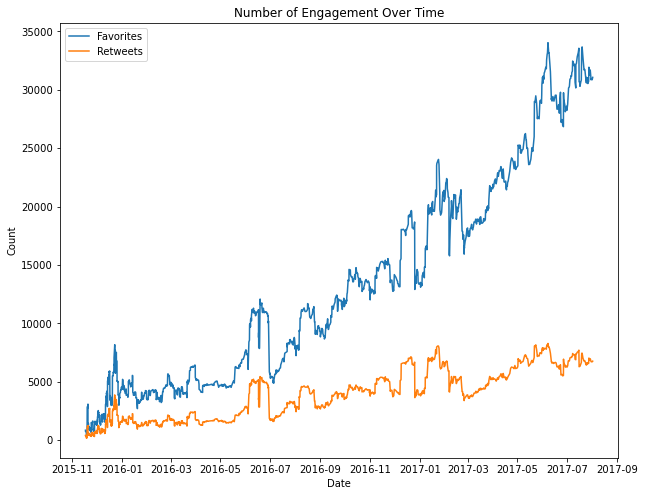

In [48]:
# Plot a line graph
plt.figure(figsize=(10,8))
plt.plot(engagement.timestamp, engagement['favorite_ma'], label='Favorites')
plt.plot(engagement.timestamp, engagement['retweet_ma'], label='Retweets')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Number of Engagement Over Time');

**ANSWER:** Calculating the moving average helps smooth out the engagement data by creating a constantly updated average count of favorites and retweets. Overall, WeRateDogs' engagement appears to be increasing over time with more users favoriting than retweeting.

##### Distribution of dog ratings

In [49]:
df['rating_numerator'].value_counts().sort_index()

0         1
1         5
2         9
3        19
4        16
5        33
6        32
7        52
8        95
9       150
10      417
11      392
12      446
13      253
14       33
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        1
80        1
84        1
88        1
99        1
121       1
144       1
165       1
204       1
420       1
1776      1
Name: rating_numerator, dtype: int64

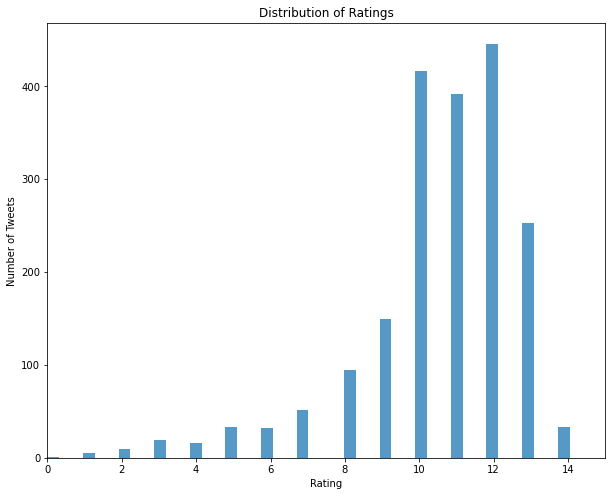

In [50]:
# Exclude the outliers above 15
plt.figure(figsize=(10,8))
sns.histplot(data=df, x='rating_numerator')
plt.xlim(0,15)
plt.ylabel('Number of Tweets')
plt.xlabel('Rating')
plt.title('Distribution of Ratings');

In [51]:
df[df['rating_numerator'] > 10]['rating_numerator'].value_counts().sum()

1142

**ANSWER:** The distribution of ratings is left-skewed. Out of a total of 1971 dogs rated by WeRateDogs, a total of 1142 dogs were rated above 10, which is almost 60%.

##### The most favorited dog breed

In [52]:
# Calculate aggregate favorite count of dog breeds
breeds = df['breed'].value_counts().keys()
breed_agg_favorite = []

for breed in breeds:
    agg_favorite = df.loc[df['breed'] == breed]['favorite_count'].sum()
    breed_agg_favorite.append([breed, agg_favorite])

In [53]:
# Sort the list by aggregate favorite count
breed_agg_favorite.sort(key=lambda x: x[1], reverse=True)
breed_agg_favorite

[['golden_retriever', 1693475],
 ['Labrador_retriever', 1116811],
 ['Pembroke', 994755],
 ['Chihuahua', 673526],
 ['Samoyed', 542991],
 ['French_bulldog', 465738],
 ['chow', 404241],
 ['pug', 320223],
 ['cocker_spaniel', 315825],
 ['Pomeranian', 299114],
 ['Cardigan', 260287],
 ['toy_poodle', 250648],
 ['malamute', 249179],
 ['Chesapeake_Bay_retriever', 232997],
 ['Eskimo_dog', 216028],
 ['German_shepherd', 203093],
 ['Lakeland_terrier', 198198],
 ['miniature_pinscher', 187889],
 ['Staffordshire_bullterrier', 187099],
 ['Great_Pyrenees', 181048],
 ['basset', 180258],
 ['Shetland_sheepdog', 154553],
 ['English_springer', 140915],
 ['Siberian_husky', 139982],
 ['flat-coated_retriever', 134333],
 ['Italian_greyhound', 128658],
 ['Rottweiler', 127719],
 ['standard_poodle', 110502],
 ['kelpie', 109828],
 ['Border_collie', 107197],
 ['American_Staffordshire_terrier', 98274],
 ['vizsla', 97402],
 ['Saluki', 96240],
 ['Border_terrier', 95046],
 ['boxer', 94951],
 ['Pekinese', 93164],
 ['Blenhe

In [54]:
breed_names = list(zip(*breed_agg_favorite[0:10]))[0] # Get names of the top 10 dog breeds
breed_favorites = list(zip(*breed_agg_favorite[0:10]))[1] # Get ratings of the top 10 dog breeds

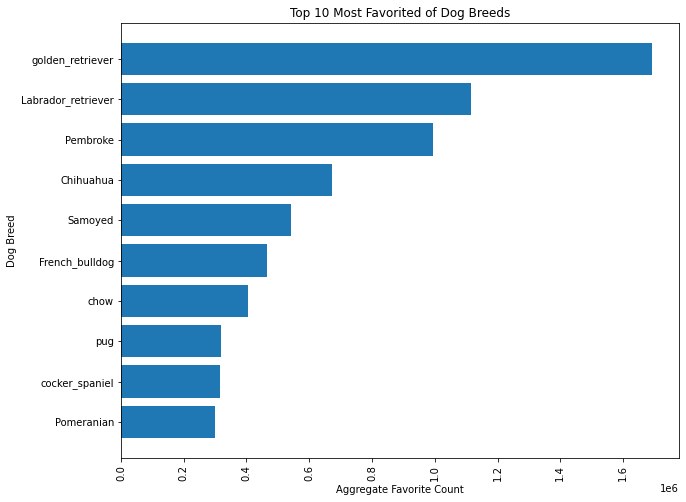

In [55]:
# Plot a histogram of the top 10 dog breeds by aggregate favorite count
plt.figure(figsize=(10,8))
plt.barh(breed_names, breed_favorites)
plt.gca().invert_yaxis()
plt.xticks(rotation=90)
plt.xlabel('Aggregate Favorite Count')
plt.ylabel('Dog Breed')
plt.title('Top 10 Most Favorited of Dog Breeds');

**ANSWER:** The bar chart above shows that the most favorited dog, with an aggregate count of more than 1.6 millions, is the Golden Retrievers, followed by the Labrador Retrievers, PembrokesHow are ratings distributed within each of the dog breeds with highest favourite counts?, and Chihuahuas in second, third, and fourth.

##### Distribution of ratings among the most favorited dog breeds

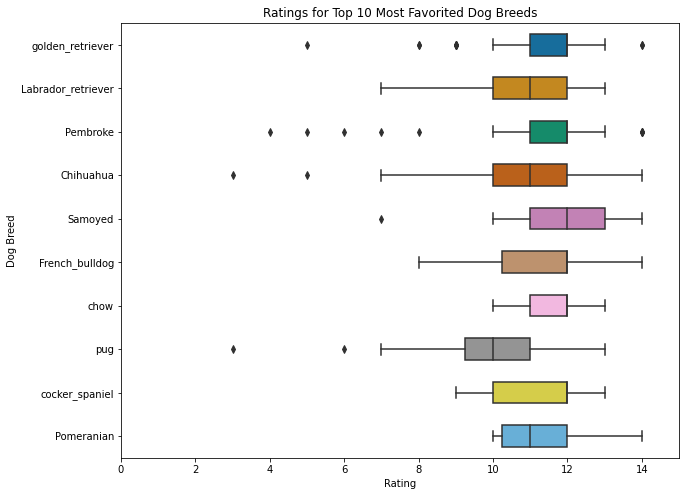

In [56]:
# Plot a boxplot of the top 10 dog breeds and their ratings
plt.figure(figsize=(10,8))
bplot = sns.boxplot(y='breed', x='rating_numerator',
                    data=df,
                    orient='h',
                    width=0.5,
                    palette="colorblind",
                    order=breed_names)
plt.xlim(0,15)
plt.ylabel('Dog Breed')
plt.xlabel('Rating')
plt.title('Ratings for Top 10 Most Favorited Dog Breeds');

**ANSWER:** The boxplot shows the distribution of ratings among the most favorited dog breeds ranked by aggregate favourite count. All the breeds range between 7 and 13, with a few outliers.